In [1]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import confusion_matrix

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [2]:
srcdir = 'data/names'
languages = ["English","French","Italian","German","Spanish"]

In [3]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [4]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names\Arabic.txt
data/names\Chinese.txt
data/names\Czech.txt
data/names\Dutch.txt
data/names\English.txt
data/names\French.txt
data/names\German.txt
data/names\Greek.txt
data/names\Irish.txt
data/names\Italian.txt
data/names\Japanese.txt
data/names\Korean.txt
data/names\Polish.txt
data/names\Portuguese.txt
data/names\Russian.txt
data/names\Scottish.txt
data/names\Spanish.txt
data/names\Vietnamese.txt


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [6]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abbas,English
1,Abbey,English
2,Abbott,English
3,Abdi,English
4,Abel,English


In [7]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [8]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [9]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [10]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with 
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector
    ### START YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

In [11]:
print(language_to_index)
print(index_to_language)
#name_representation("Russell", 74)
#lang_representation("English", language_to_index)
#print(name_representation("Abel", len_alphabet))

{'English': 0, 'French': 1, 'German': 2, 'Italian': 3, 'Spanish': 4}
{0: 'English', 1: 'French', 2: 'German', 3: 'Italian', 4: 'Spanish'}


### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [12]:
test_split = 0.2

### START YOUR CODE
# Shuffle and split names data
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(names["name"], names["lang"], test_size = test_split, shuffle=True)

print("Train")
print(X_train_raw.shape)
print(y_train_raw.shape)
print("Test")
print(X_test_raw.shape)
print(y_test_raw.shape)

### END YOUR CODE

Train
(4540,)
(4540,)
Test
(1136,)
(1136,)


In [13]:
### START YOUR CODE

# Map train and test data into vector space (one-hot-vectors)

print("Train")
X_train = np.array([name_representation(name=n, maxlen=maxlen) for n in X_train_raw])
y_train = np.array([lang_representation(language=l, language_to_index=language_to_index) for l in y_train_raw])
print(X_train.shape)
print(y_train.shape)

print("Test")
X_test = np.array([name_representation(name=n, maxlen=maxlen) for n in X_test_raw])
y_test = np.array([lang_representation(language=l, language_to_index=language_to_index) for l in y_test_raw])
print(X_test.shape)
print(y_test.shape)

### END YOUR CODE

Train
(4540, 18, 74)
(4540, 5)
Test
(1136, 18, 74)
(1136, 5)


Possibly, pack the data into a Dataset (e.g. when working with in PyTorch)

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [14]:
### START YOUR CODE
from tensorflow import keras
from keras import layers
# SimpleRNN, single layer with tf.keras....

n_hidden = 128
n_languages = len(language_to_index)
model = keras.Sequential()
model.add(layers.SimpleRNN(units=n_hidden, return_sequences=False, activation="tanh", input_shape=(maxlen, len_alphabet)))
model.add(layers.Dense(units=n_languages, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
model.summary()

### END YOUR CODE

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               25984     
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 26,629
Trainable params: 26,629
Non-trainable params: 0
_________________________________________________________________


In [15]:
### START YOUR CODE
batch_size = 128
nepochs = 50

log = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=nepochs,
    validation_data=(X_test, y_test)
)

### END YOUR CODE

Epoch 1/50
36/36 [==============================] - 2s 14ms/step - loss: 1.0842 - accuracy: 0.6401 - val_loss: 0.9629 - val_accuracy: 0.6646
Epoch 2/50
36/36 [==============================] - 0s 10ms/step - loss: 0.8390 - accuracy: 0.7115 - val_loss: 0.8735 - val_accuracy: 0.7025
Epoch 3/50
36/36 [==============================] - 0s 11ms/step - loss: 0.7511 - accuracy: 0.7348 - val_loss: 0.7899 - val_accuracy: 0.7201
Epoch 4/50
36/36 [==============================] - 0s 10ms/step - loss: 0.6910 - accuracy: 0.7577 - val_loss: 0.7463 - val_accuracy: 0.7315
Epoch 5/50
36/36 [==============================] - 0s 11ms/step - loss: 0.6474 - accuracy: 0.7694 - val_loss: 0.7274 - val_accuracy: 0.7368
Epoch 6/50
36/36 [==============================] - 0s 10ms/step - loss: 0.6471 - accuracy: 0.7626 - val_loss: 0.7248 - val_accuracy: 0.7456
Epoch 7/50
36/36 [==============================] - 0s 10ms/step - loss: 0.6014 - accuracy: 0.7828 - val_loss: 0.7001 - val_accuracy: 0.7403
Epoch 8/50
36

36/36 [==============================] - 0s 4ms/step - loss: 1.0383 - accuracy: 0.7658


[1.038312315940857, 0.7658450603485107]

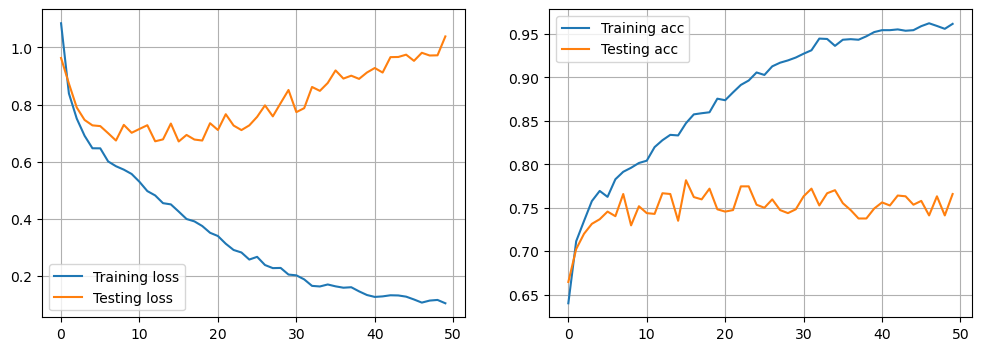

In [16]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

model.evaluate(x=X_test, y=y_test)

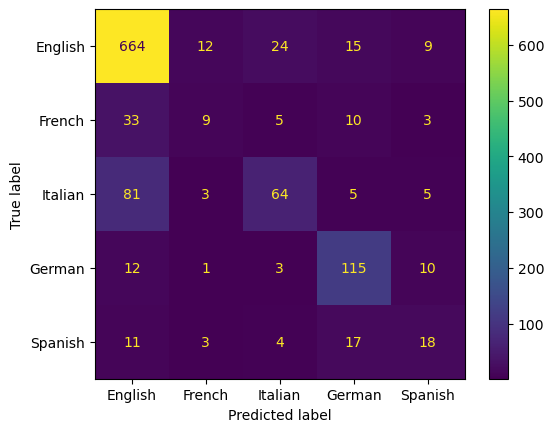

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = np.array([np.argmax(y) for y in model.predict(X_test)])
y_true = np.array([np.argmax(y) for y in y_test])

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=languages)
disp.plot()

#### Findings

We can observe overfitting happening already early on in the testing process.  
From the confusion matrix we can see the big class inbalances. The classifier works OK for English which is by far the most represented class, but really works poorly on  French and also Spanish especially. Also Italian seems to be very difficult to distinish from English for the classifier. Overall it's a quite bad classifier, although the accuracy is 0.7658.

### Implement Model with several SimpleRNN Layers

In [18]:
### START YOUR CODE

n_hidden = 128

model = keras.Sequential()
model.add(layers.SimpleRNN(units=n_hidden, return_sequences=True, activation="tanh", input_shape=(maxlen, len_alphabet)))
model.add(layers.SimpleRNN(units=n_hidden, return_sequences=True))
model.add(layers.SimpleRNN(units=n_hidden, return_sequences=False))
model.add(layers.Dense(units=n_languages, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
model.summary()

### END YOUR CODE

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 18, 128)           25984     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 18, 128)           32896     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 92,421
Trainable params: 92,421
Non-trainable params: 0
_________________________________________________________________


In [19]:
### START YOUR CODE

batch_size = 128
nepochs = 50

log = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=nepochs,
    validation_data=(X_test, y_test)
)

### END YOUR CODE

Epoch 1/50
36/36 [==============================] - 2s 43ms/step - loss: 1.0593 - accuracy: 0.6419 - val_loss: 0.8852 - val_accuracy: 0.6822
Epoch 2/50
36/36 [==============================] - 1s 34ms/step - loss: 0.7723 - accuracy: 0.7267 - val_loss: 0.7581 - val_accuracy: 0.7368
Epoch 3/50
36/36 [==============================] - 1s 35ms/step - loss: 0.6606 - accuracy: 0.7597 - val_loss: 0.7227 - val_accuracy: 0.7394
Epoch 4/50
36/36 [==============================] - 1s 36ms/step - loss: 0.5854 - accuracy: 0.7892 - val_loss: 0.6874 - val_accuracy: 0.7438
Epoch 5/50
36/36 [==============================] - 1s 34ms/step - loss: 0.5329 - accuracy: 0.8068 - val_loss: 0.7496 - val_accuracy: 0.7386
Epoch 6/50
36/36 [==============================] - 1s 35ms/step - loss: 0.4972 - accuracy: 0.8161 - val_loss: 0.6746 - val_accuracy: 0.7570
Epoch 7/50
36/36 [==============================] - 1s 36ms/step - loss: 0.4484 - accuracy: 0.8390 - val_loss: 0.6476 - val_accuracy: 0.7782
Epoch 8/50
36

36/36 [==============================] - 0s 7ms/step - loss: 1.0365 - accuracy: 0.7482


[1.0365034341812134, 0.7482394576072693]

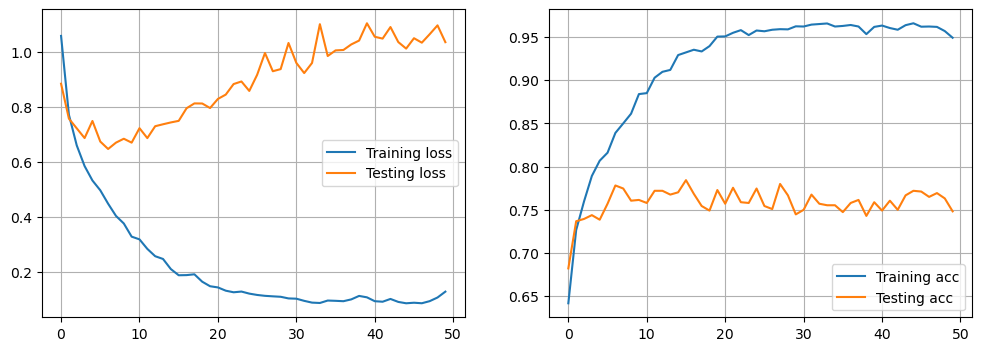

In [20]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

model.evaluate(x=X_test, y=y_test)

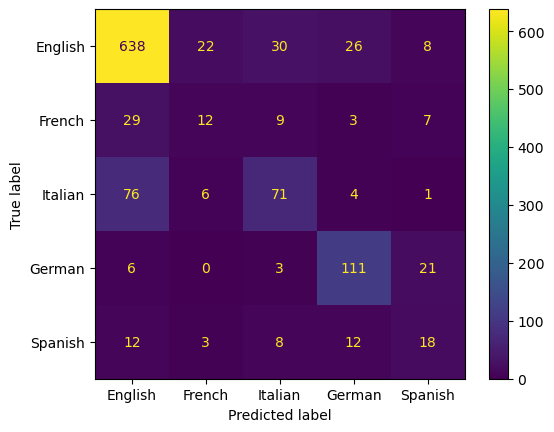

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = np.array([np.argmax(y) for y in model.predict(X_test)])
y_true = np.array([np.argmax(y) for y in y_test])

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=languages)
disp.plot()

#### Findings
The new accuracy is 0.7482. This is even a slight performance decrease. The overfitting problem remains and also the classifier didn't really improve for classes that are underrepresented.


### Class Imbalance Handling

Choose a method to address the class imbalance seen in the given example.
- minority resampling 
- class weights in the loss

Implement it and incorporate it in the training.
Evaluate the results and compare it with the results obtained with the unbalanced training.  

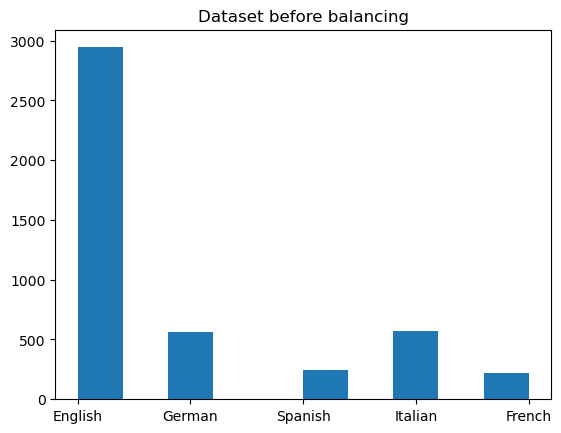

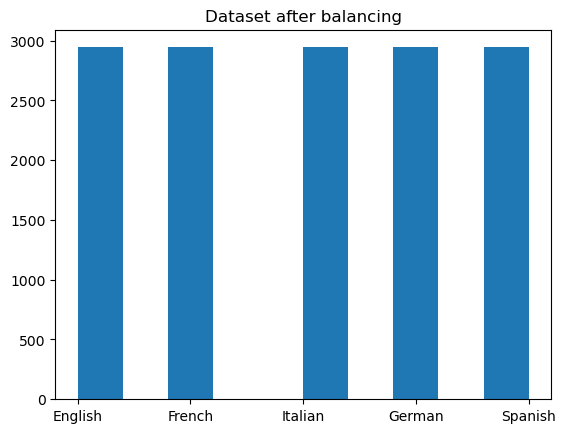

Train (upsampled)
(14720, 18, 74)
(14720, 5)
Test (same as before)
(1136, 18, 74)
(1136, 5)


In [22]:
### START YOUR CODE


plt.title("Dataset before balancing")
df_train = pd.concat([X_train_raw, y_train_raw], axis=1)
plt.hist(df_train["lang"])
plt.show()

""" Minority resampling """
# We only extend the training set, we don't change anything about the test set to be able to compare the results to the previous tests
max_samples = np.max(df_train["lang"].value_counts())
df_train_balanced = df_train[df_train["lang"] == "English"]
for lang in languages:
    if lang == "English":
        pass
    else:
        df_class = df_train[df_train["lang"] == lang]
        df_class = df_class.sample(n=max_samples, replace=True)
        df_train_balanced = pd.concat([df_train_balanced, df_class])

plt.title("Dataset after balancing")
plt.hist(df_train_balanced["lang"])
plt.show()


X_train = np.array([name_representation(name=n, maxlen=maxlen) for n in df_train_balanced["name"]])
y_train = np.array([lang_representation(language=l, language_to_index=language_to_index) for l in df_train_balanced["lang"]])

print("Train (upsampled)")
print(X_train.shape)
print(y_train.shape)
print("Test (same as before)")
print(X_test.shape)
print(y_test.shape)

### END YOUR CODE

In [23]:
n_hidden = 128

model = keras.Sequential()
model.add(layers.SimpleRNN(units=n_hidden, return_sequences=True, activation="tanh", input_shape=(maxlen, len_alphabet)))
model.add(layers.SimpleRNN(units=n_hidden, return_sequences=True))
model.add(layers.SimpleRNN(units=n_hidden, return_sequences=False))
model.add(layers.Dense(units=n_languages, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

batch_size = 128
nepochs = 50

log = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=nepochs,
    validation_data=(X_test, y_test)
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 18, 128)           25984     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 18, 128)           32896     
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 92,421
Trainable params: 92,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
115/115 [==============================] - 4s 27ms/step - loss: 0.9578 - accuracy: 0.6222 - val_loss: 0.9284 - val_accuracy: 0.6171
Epoch 2/50
115/115 [===================

36/36 [==============================] - 0s 8ms/step - loss: 1.1269 - accuracy: 0.7667


[1.1268852949142456, 0.7667253613471985]

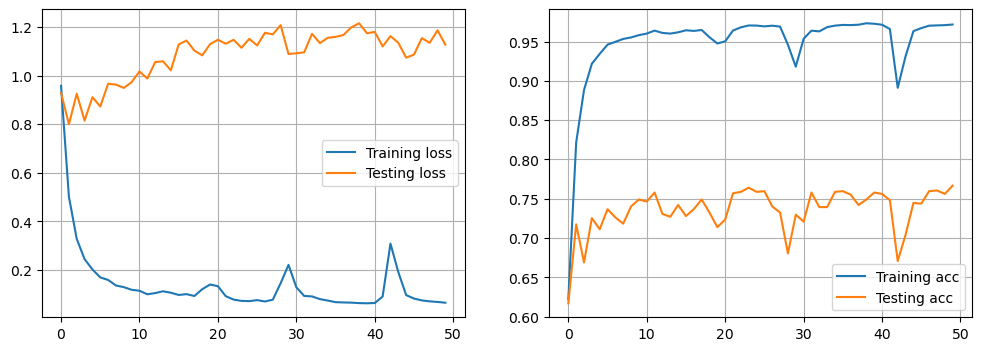

In [24]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

model.evaluate(x=X_test, y=y_test)

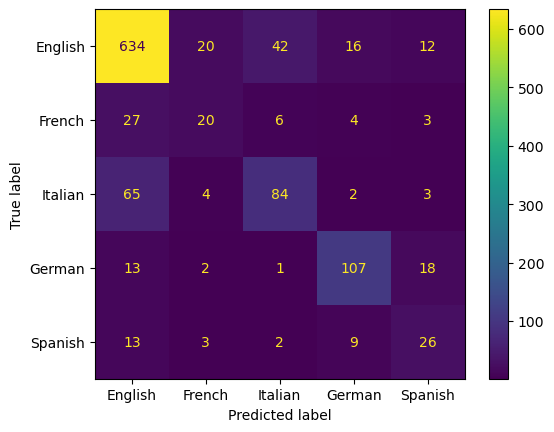

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = np.array([np.argmax(y) for y in model.predict(X_test)])
y_true = np.array([np.argmax(y) for y in y_test])

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=languages)
disp.plot()

### Findings:
Sadly the performance doesn't really improve or improves only slightly for the minority classes as we cann see in the confusion matrix.